In [22]:
import pandas as pd
import numpy as np
from numpy import zeros, newaxis

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from sklearn.preprocessing import MinMaxScaler
import math, time
from math import sqrt
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

import statistics as st
import scipy as sc
from torch.optim.lr_scheduler import StepLR

In [23]:
#Loading in data
url = './^SPX.csv'
meta = pd.read_csv(url)
meta = meta.dropna(how='any',axis=0) #If there is missing data
meta['Date'].apply(pd.to_datetime) #For ease of adjusting dates later on
len(meta.index)

7381

In [7]:
meta = meta[['Close'] + [col for col in meta if col not in ['Adj Close', 'Close', 'Date']] + ['Adj Close', 'Date']]

In [8]:
#Sorting dates
meta = meta.sort_values('Date')
meta.head()

,Close,Open,High,Low,Volume,Adj Close,Date
0,459.109985,459.209991,459.269989,457.200012,262450000,459.109985,1995-01-03
1,460.709991,459.130005,460.720001,457.559998,319510000,460.709991,1995-01-04
2,460.339996,460.730011,461.299988,459.750000,309050000,460.339996,1995-01-05
3,460.679993,460.380005,462.489990,459.470001,308070000,460.679993,1995-01-06
4,460.829987,460.670013,461.769989,459.739990,278790000,460.829987,1995-01-09


In [22]:
print(max(meta['Open']))
print(max(meta['High']))
print(max(meta['Low']))
print(max(meta['Close']))
print(max(meta['Volume']))

5257.970215
5264.850098
5245.819824
5254.350098
11456230000


In [23]:
print(min(meta['Open']))
print(min(meta['High']))
print(min(meta['Low']))
print(min(meta['Close']))
print(min(meta['Volume']))

459.130005
459.269989
457.200012
459.109985
14990000


In [24]:
print(st.mean(meta['Open']))
print(st.mean(meta['High']))
print(st.mean(meta['Low']))
print(st.mean(meta['Close']))
print(st.mean(meta['Volume']))

1822.843907984013
1833.6368766657633
1811.344811371359
1823.2272036020865
2859930593.4155264


In [25]:
print(np.var(meta['Open']))
print(np.var(meta['High']))
print(np.var(meta['Low']))
print(np.var(meta['Close']))
print(np.var(meta['Volume']))

1212185.4354489394
1224126.1751498962
1199592.111242419
1212569.011473039
2.976937673297493e+18


In [26]:
print(sc.stats.skew(meta['Open']))
print(sc.stats.skew(meta['High']))
print(sc.stats.skew(meta['Low']))
print(sc.stats.skew(meta['Close']))
print(sc.stats.skew(meta['Volume']))

1.2784596808035373
1.2794310075305104
1.277882968853118
1.2787870888531467
0.38426262201575595


In [27]:
print(sc.stats.kurtosis(meta['Open']))
print(sc.stats.kurtosis(meta['High']))
print(sc.stats.kurtosis(meta['Low']))
print(sc.stats.kurtosis(meta['Close']))
print(sc.stats.kurtosis(meta['Volume']))

0.6456968959483533
0.6446334877208151
0.6475232311944512
0.6461868705335472
-0.07092310318448103


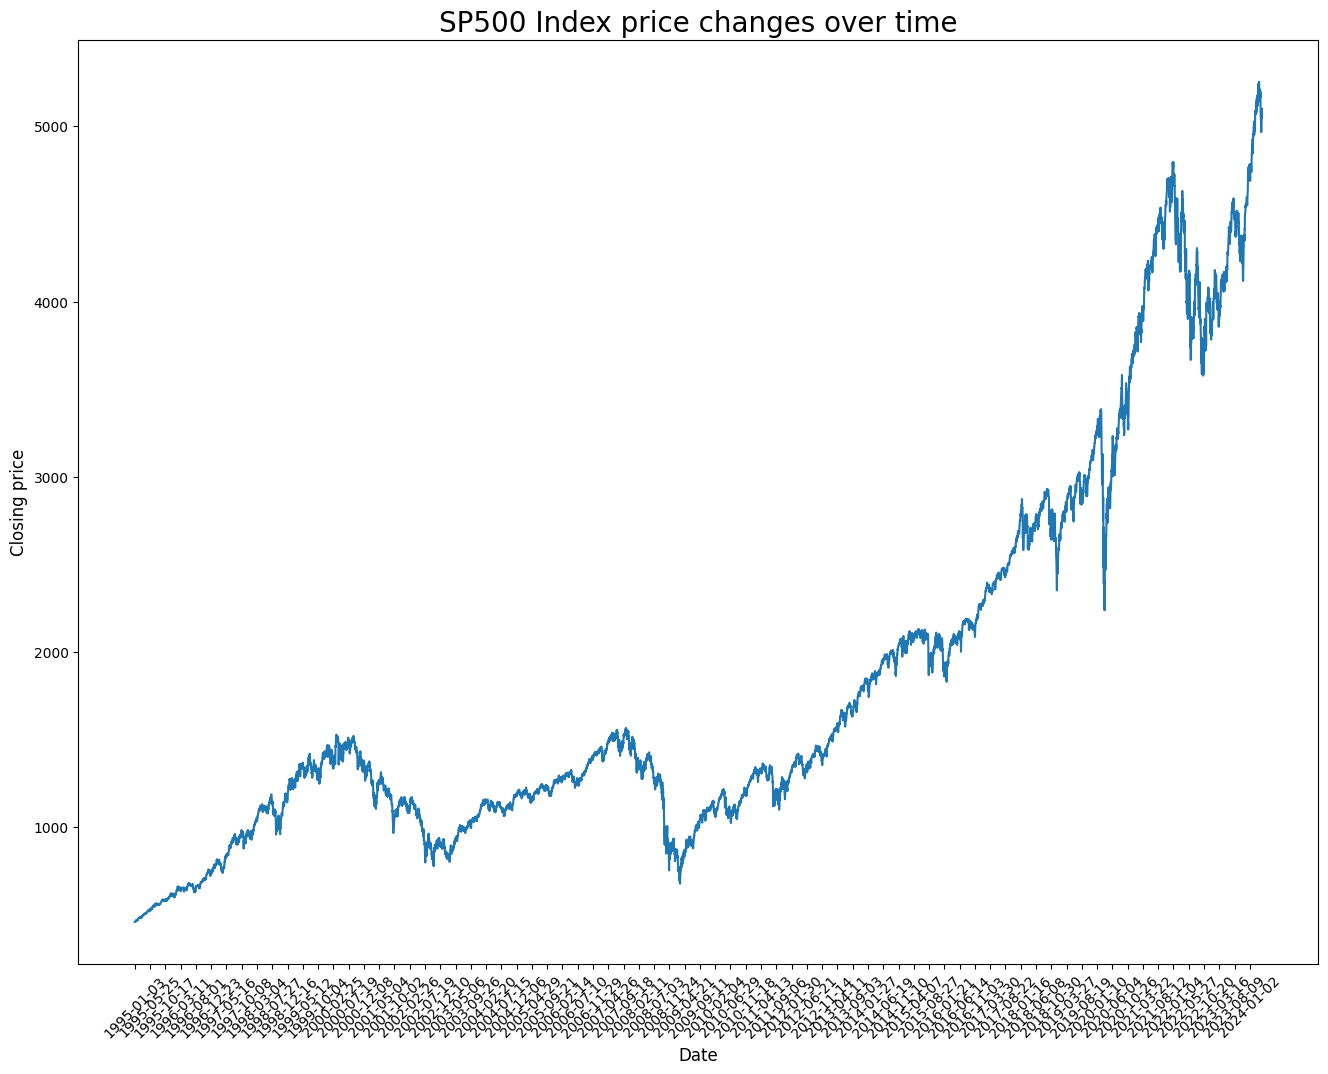

In [28]:
plt.figure(figsize = (16,12))
plt.plot(meta.Date, meta.Close)
plt.xticks(range(0,meta.shape[0],100),meta['Date'].loc[::100],rotation=45)
plt.xlabel('Date',fontsize=12)
plt.ylabel('Closing price',fontsize=12)
plt.title('SP500 Index price changes over time',fontsize=20)
plt.show()

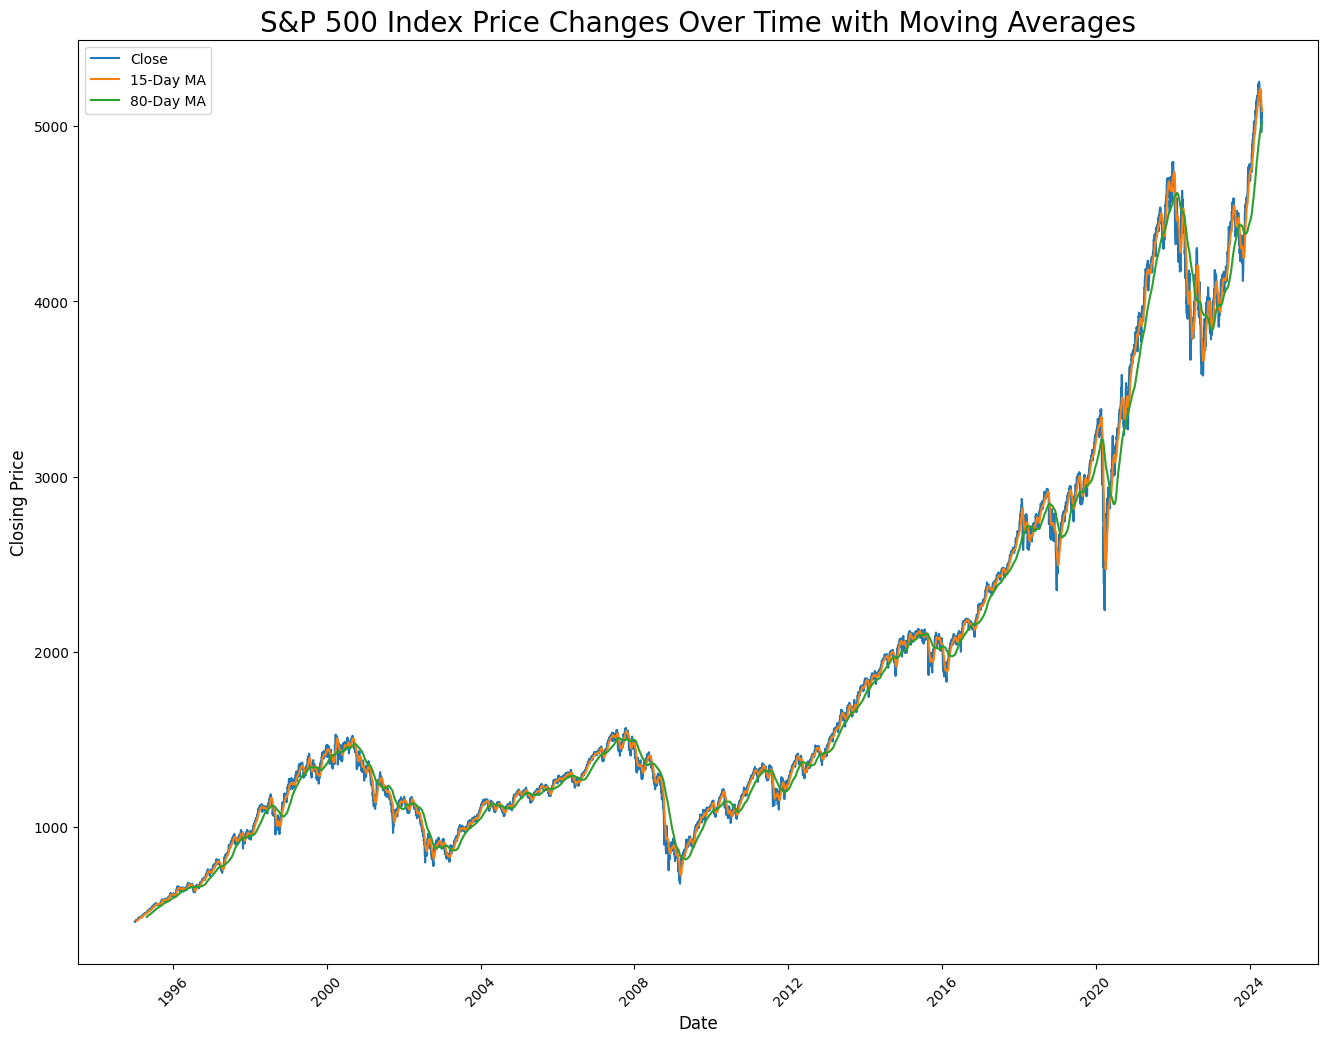

In [33]:
# Convert 'Date' column to datetime type (if not already done)
meta['Date'] = pd.to_datetime(meta['Date'])

# Set 'Date' as the index of the DataFrame
meta.set_index('Date', inplace=True)

# Now, compute the short and long moving averages on the numeric columns only
short_MA = meta.rolling(window=15).mean()
long_MA = meta.rolling(window=80).mean()

# To plot these on top of your existing plot:
plt.figure(figsize=(16,12))
plt.plot(meta.index, meta['Close'], label='Close')
plt.plot(short_MA.index, short_MA['Close'], label='15-Day MA')
plt.plot(long_MA.index, long_MA['Close'], label='80-Day MA')
plt.xticks(rotation=45)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Closing Price', fontsize=12)
plt.title('S&P 500 Index Price Changes Over Time with Moving Averages', fontsize=20)
plt.legend()
plt.show()


In [46]:
#Preparing inputs
from sklearn.model_selection import train_test_split
training_set, test_set = train_test_split(meta, test_size = 0.2, random_state = 21)

# Assuming your DataFrame 'meta' has 5 columns of data and 1 column for the date
# And you need to use columns 1 to 4 as inputs (0 being the target)

X_train_array = training_set.iloc[:, 1:5].values  # Assuming the first column is the target
y_train_array = training_set.iloc[:, 0:1].values

X_test_array = test_set.iloc[:, 1:5].values
y_test_array = test_set.iloc[:, 0:1].values


In [47]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_array = scaler.fit_transform(X_train_array)
X_test_array = scaler.fit_transform(X_test_array)
y_train_array = scaler.fit_transform(y_train_array)
y_test_array = scaler.fit_transform(y_test_array)

In [48]:
training = torch.tensor(X_train_array, dtype=torch.float32)
test = torch.tensor(X_test_array, dtype=torch.float32)

In [49]:
trainlabels = torch.tensor(y_train_array, dtype=torch.float32)
testlabels = torch.tensor(y_test_array, dtype=torch.float32)

In [50]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(num_inputs, num_hiddens)  # Correct variable names here
        nn.init.kaiming_uniform_(self.hidden.weight)  # Initializing weights
        self.activation = nn.ReLU()
        self.out = nn.Linear(num_hiddens, num_outputs)  # Correct variable names here

    def forward(self, X):
        X = self.hidden(X)
        X = self.activation(X)
        X = self.out(X)
        return X


In [51]:
#Model specifics
num_input, num_output, num_hidden = 4, 1, 4
model_1 = MLP(num_input, num_output, num_hidden)

In [52]:
loss = nn.MSELoss()

In [53]:
#Training the model
train_hist_mlp1 = np.zeros(100)
net = model_1
optimizer = torch.optim.SGD(net.parameters(), lr = 0.5)
for epoch in range(100):
    optimizer.zero_grad()
    y_predmlp1 = net(training)
    l = loss(y_predmlp1, trainlabels)
    train_hist_mlp1[epoch] = l.item()
    print("Epoch ", epoch, "MSE: ", l)
    l.backward()
    optimizer.step()

Epoch  0 MSE:  tensor(0.1319, grad_fn=<MseLossBackward0>)
Epoch  1 MSE:  tensor(0.0895, grad_fn=<MseLossBackward0>)
Epoch  2 MSE:  tensor(0.0655, grad_fn=<MseLossBackward0>)
Epoch  3 MSE:  tensor(0.0521, grad_fn=<MseLossBackward0>)
Epoch  4 MSE:  tensor(0.0439, grad_fn=<MseLossBackward0>)
Epoch  5 MSE:  tensor(0.0382, grad_fn=<MseLossBackward0>)
Epoch  6 MSE:  tensor(0.0362, grad_fn=<MseLossBackward0>)
Epoch  7 MSE:  tensor(0.0339, grad_fn=<MseLossBackward0>)
Epoch  8 MSE:  tensor(0.0360, grad_fn=<MseLossBackward0>)
Epoch  9 MSE:  tensor(0.0351, grad_fn=<MseLossBackward0>)
Epoch  10 MSE:  tensor(0.0408, grad_fn=<MseLossBackward0>)
Epoch  11 MSE:  tensor(0.0392, grad_fn=<MseLossBackward0>)
Epoch  12 MSE:  tensor(0.0472, grad_fn=<MseLossBackward0>)
Epoch  13 MSE:  tensor(0.0423, grad_fn=<MseLossBackward0>)
Epoch  14 MSE:  tensor(0.0501, grad_fn=<MseLossBackward0>)
Epoch  15 MSE:  tensor(0.0409, grad_fn=<MseLossBackward0>)
Epoch  16 MSE:  tensor(0.0460, grad_fn=<MseLossBackward0>)
Epoch  

In [55]:
y_pred_test = model_1(test)
y_train_pred_origmlp = scaler.inverse_transform(y_predmlp1.detach().numpy())
y_train_origmlp = scaler.inverse_transform(trainlabels.detach().numpy())
y_test_predmlp = scaler.inverse_transform(y_pred_test.detach().numpy())
y_testmlp = scaler.inverse_transform(testlabels.detach().numpy())

**Section 2: Multilayer perceptron model with the sliding window method (Model 2)**

In [57]:
#Preparing inputs
closing = meta[['Close']]

In [58]:
scaler = MinMaxScaler(feature_range=(0, 1))
closing['Close'] = scaler.fit_transform(closing['Close'].values.reshape(-1,1))

C:\Users\23713\AppData\Local\Temp\ipykernel_21216\3218315939.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closing['Close'] = scaler.fit_transform(closing['Close'].values.reshape(-1,1))


In [59]:
def split_data(data, timeframe):
    numpydata = data.to_numpy() 
    data = []
    
    for index in range(len(numpydata) - timeframe): #Subtracting timeframe because the last few inputs will have NaN values
        data.append(numpydata[index: index + timeframe])
    
    data = np.array(data);    
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
timeframe = 31
x_train, y_train, x_test, y_test = split_data(closing, timeframe)

In [60]:

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train= torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [61]:
x_train.shape

torch.Size([5880, 30, 1])

In [63]:
x_train = torch.transpose(x_train, 1, 2)
x_train = x_train.reshape(5880, 30)

In [64]:
x_test.shape

torch.Size([1470, 30, 1])

In [66]:
x_test = torch.transpose(x_test, 1, 2)
x_test = x_test.reshape(1470, 30)

In [98]:
def dropout_layer(X, dropout):
  assert 0 <= dropout <= 1
  # In this case, all elements are dropped out
  if dropout == 1:
    return torch.zeros_like(X)
    # In this case, all elements are kept
  if dropout == 0:
    return X
  mask = (torch.rand(X.shape) > dropout).float()
  return mask * X / (1.0 - dropout)

In [99]:
#Model structure
num_input, num_output, num_hidden = 30, 1, 4
model_1 = MLP(num_input, num_output, num_hidden)

In [100]:
#Training the model
train_hist_mlp2 = np.zeros(100)
net = model_1.train()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.5)
for epoch in range(100):
    optimizer.zero_grad()
    y_pred = net(x_train)
    l = loss(y_pred, y_train)
    train_hist_mlp2[epoch] = l.item()
    print("Epoch ", epoch, "MSE: ", l)
    l.backward()
    optimizer.step()

Epoch  0 MSE:  tensor(0.0506, grad_fn=<MseLossBackward0>)
Epoch  1 MSE:  tensor(0.0123, grad_fn=<MseLossBackward0>)
Epoch  2 MSE:  tensor(0.0082, grad_fn=<MseLossBackward0>)
Epoch  3 MSE:  tensor(0.0078, grad_fn=<MseLossBackward0>)
Epoch  4 MSE:  tensor(0.0075, grad_fn=<MseLossBackward0>)
Epoch  5 MSE:  tensor(0.0072, grad_fn=<MseLossBackward0>)
Epoch  6 MSE:  tensor(0.0068, grad_fn=<MseLossBackward0>)
Epoch  7 MSE:  tensor(0.0066, grad_fn=<MseLossBackward0>)
Epoch  8 MSE:  tensor(0.0061, grad_fn=<MseLossBackward0>)
Epoch  9 MSE:  tensor(0.0057, grad_fn=<MseLossBackward0>)
Epoch  10 MSE:  tensor(0.0055, grad_fn=<MseLossBackward0>)
Epoch  11 MSE:  tensor(0.0053, grad_fn=<MseLossBackward0>)
Epoch  12 MSE:  tensor(0.0051, grad_fn=<MseLossBackward0>)
Epoch  13 MSE:  tensor(0.0049, grad_fn=<MseLossBackward0>)
Epoch  14 MSE:  tensor(0.0046, grad_fn=<MseLossBackward0>)
Epoch  15 MSE:  tensor(0.0044, grad_fn=<MseLossBackward0>)
Epoch  16 MSE:  tensor(0.0044, grad_fn=<MseLossBackward0>)
Epoch  

In [101]:
y_test_pred = model_1(x_test)

In [102]:
y_train_pred_origmlp2 = scaler.inverse_transform(y_pred.detach().numpy())
y_train_origmlp2 = scaler.inverse_transform(y_train.detach().numpy())

In [103]:
y_test_predmlp2 = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test_origmlp2 = scaler.inverse_transform(y_test.detach().numpy())

# **Part 3: Model performance**

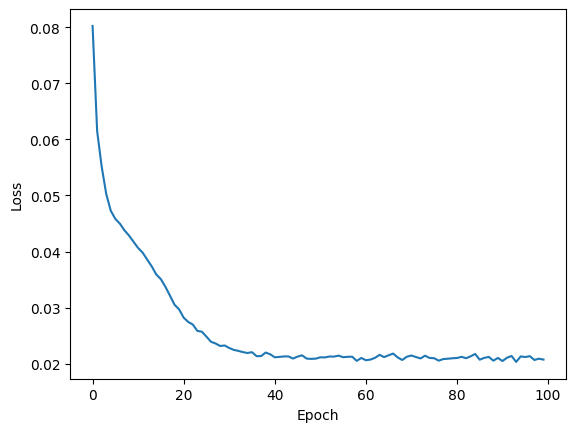

In [104]:
#Training loss for MLP model 1
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_hist_mlp1)

Epoch 0: Training MSE: 0.0802270919084549, Validation MSE: 0.05979171395301819
Epoch 1: Training MSE: 0.06151619926095009, Validation MSE: 0.05452008545398712
Epoch 2: Training MSE: 0.05512186884880066, Validation MSE: 0.04979005455970764
Epoch 3: Training MSE: 0.05025985464453697, Validation MSE: 0.04677363112568855
Epoch 4: Training MSE: 0.047264352440834045, Validation MSE: 0.04529830440878868
Epoch 5: Training MSE: 0.04581518471240997, Validation MSE: 0.04433583840727806
Epoch 6: Training MSE: 0.04497217386960983, Validation MSE: 0.04297798499464989
Epoch 7: Training MSE: 0.043787360191345215, Validation MSE: 0.04252177104353905
Epoch 8: Training MSE: 0.04285160452127457, Validation MSE: 0.040285561233758926
Epoch 9: Training MSE: 0.04173275828361511, Validation MSE: 0.03994787484407425
Epoch 10: Training MSE: 0.04063495993614197, Validation MSE: 0.03917726129293442
Epoch 11: Training MSE: 0.039795879274606705, Validation MSE: 0.03785211592912674
Epoch 12: Training MSE: 0.038563162

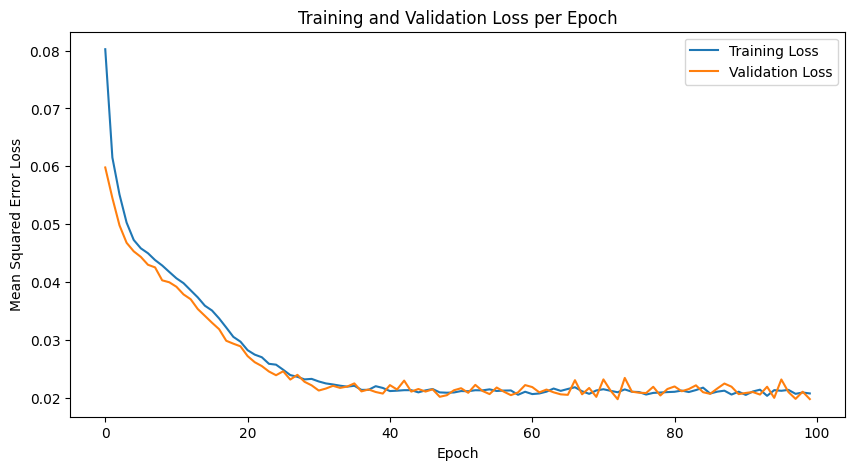

In [96]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming the rest of your code is set up correctly
# Model specifics
num_input, num_output, num_hidden = 4, 1, 4
model_1 = MLP(num_input, num_output, num_hidden)
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.5)

# Storage for loss history
train_hist_mlp1 = np.zeros(100)
val_hist_mlp1 = np.zeros(100)

# Training the model with validation loss computation
for epoch in range(100):
    optimizer.zero_grad()
    
    # Training step
    y_predmlp1 = model_1(training)
    l_train = loss(y_predmlp1, trainlabels)
    l_train.backward()
    optimizer.step()
    
    # Validation step
    with torch.no_grad():
        y_pred_val = model_1(test)
        l_val = loss(y_pred_val, testlabels)
    
    # Store losses
    train_hist_mlp1[epoch] = l_train.item()
    val_hist_mlp1[epoch] = l_val.item()
    
    print(f"Epoch {epoch}: Training MSE: {l_train.item()}, Validation MSE: {l_val.item()}")

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_hist_mlp1, label='Training Loss')
plt.plot(val_hist_mlp1, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()


In [105]:
#Training RMSE for MLP model 1
TrainRMSE = sqrt(mean_squared_error(y_train_origmlp, y_train_pred_origmlp))
print(TrainRMSE)

68.38377243199771


In [106]:
#Testing RMSE for MLP model 1
TestRMSE = sqrt(mean_squared_error(y_testmlp, y_test_predmlp))
print(TestRMSE)

64.07453393070838


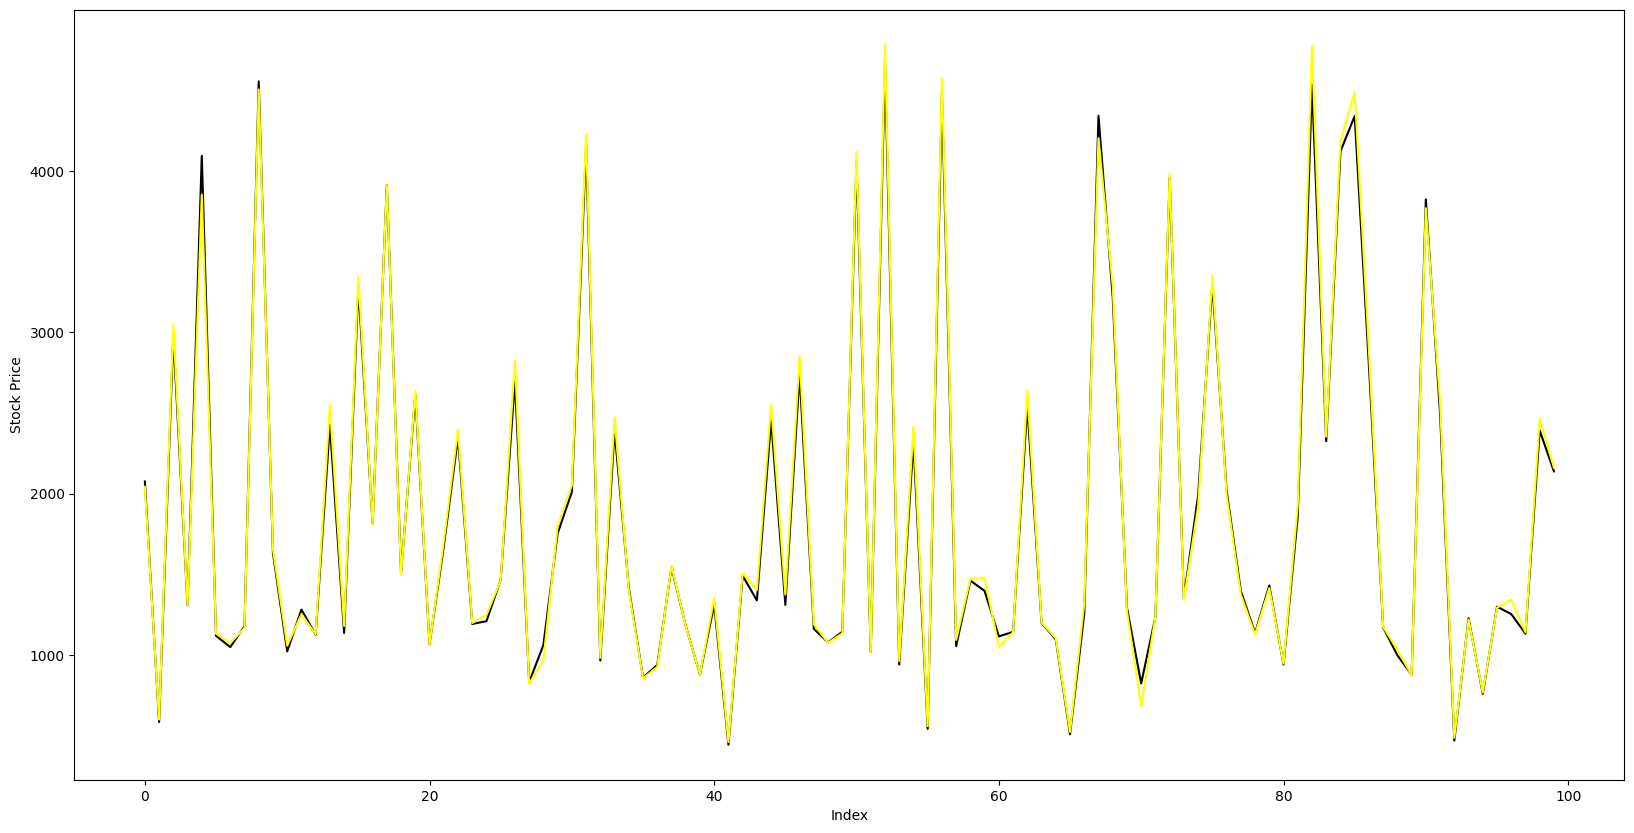

In [107]:
#Actual vs predicted prices for MLP model 1
plt.figure(figsize = (20,10))
plt.plot(y_test_predmlp[0:100], color = 'black')
plt.plot(y_testmlp[0:100], color = 'yellow')
plt.xlabel('Index')
plt.ylabel('Stock Price');

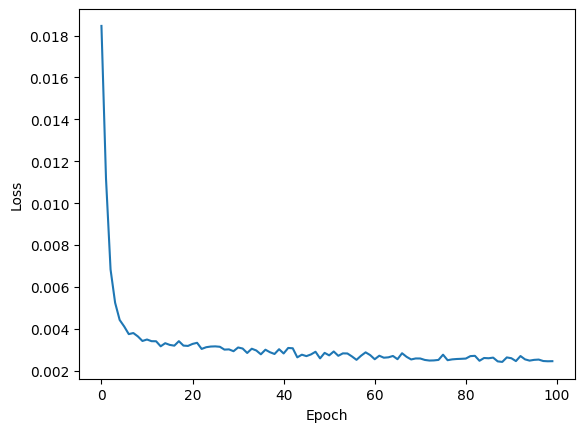

In [80]:
#Training loss for MLP model 2
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_hist_mlp2)

In [120]:
#Training RMSE for MLP model 2
TrainRMSE = sqrt(mean_squared_error(y_train_origmlp2, y_train_pred_origmlp2))
print(TrainRMSE)

215.2835067562074


In [121]:
#Testing RMSE for MLP model 2
TestRMSE = sqrt(mean_squared_error(y_test_origmlp2, y_test_predmlp2))
print(TestRMSE)

832.2753450631587


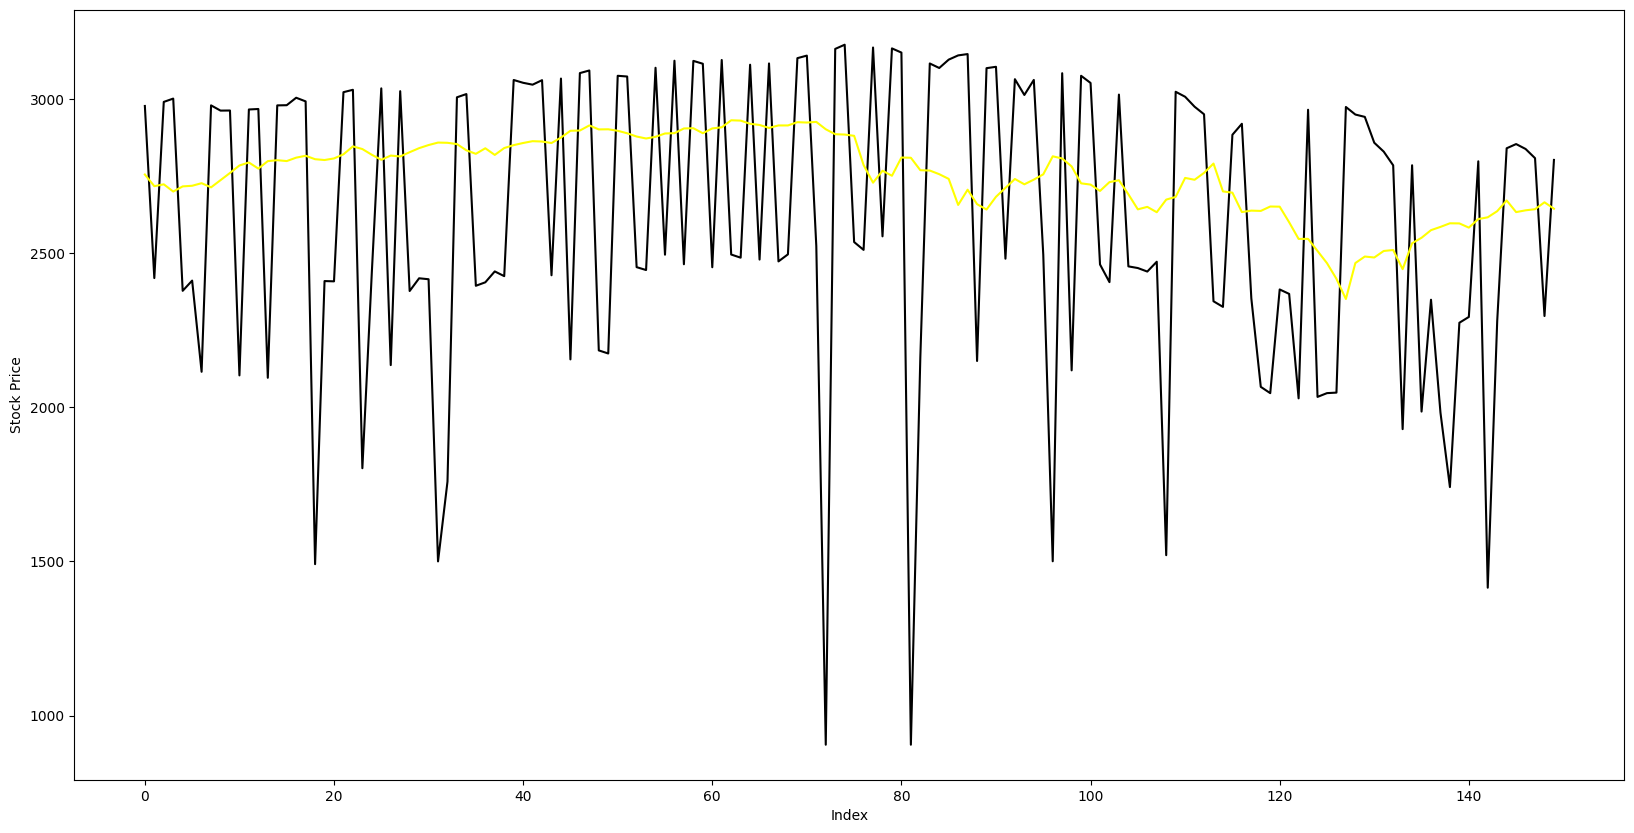

In [122]:
#Actual vs predicted prices for MLP model 2
plt.figure(figsize = (20,10))
plt.plot(y_test_predmlp2[0:150], color = 'black')
plt.plot(y_test_origmlp2[0:150], color = 'yellow')
plt.xlabel('Index')
plt.ylabel('Stock Price');

In [123]:
#Additional preparation
mlp1_array_plot = np.append(y_test_predmlp[0:100], y_testmlp[0:100], axis = 1)
mlp1_plot_data = pd.DataFrame(mlp1_array_plot)
mlp1_plot_data.columns = ['Prediction', 'Actual']

mlp2_array_plot = np.append(y_test_predmlp2[0:150], y_test_origmlp2[0:150], axis = 1)
mlp2_plot_data = pd.DataFrame(mlp2_array_plot)
mlp2_plot_data.columns = ['Prediction', 'Actual']

Text(0, 0.5, 'Closing')

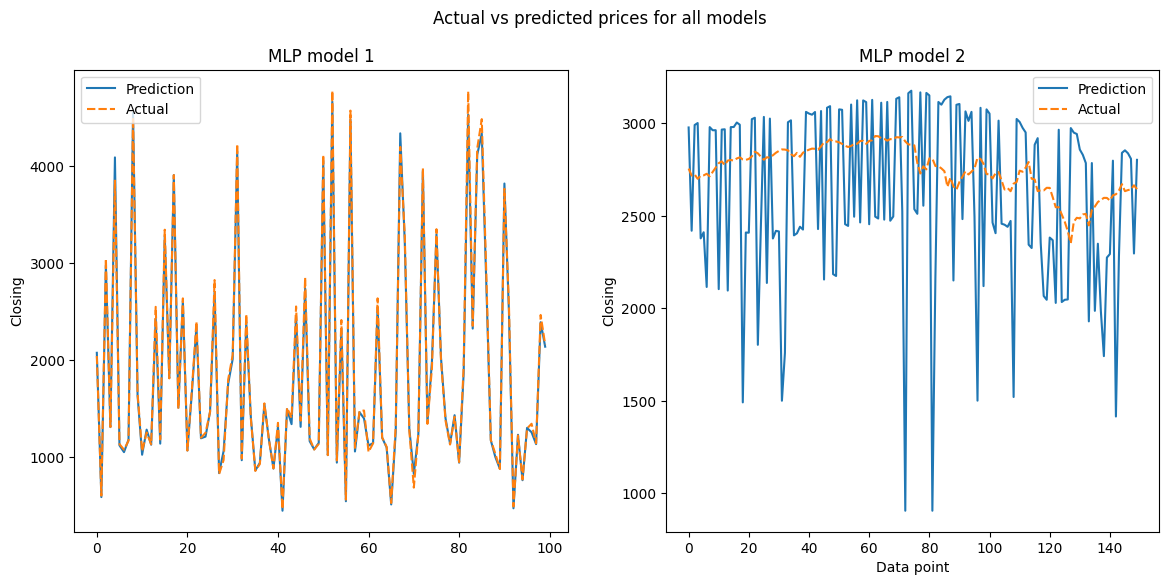

In [124]:
#All plots next to each other
fig, axes = plt.subplots(1, 2, sharex = False, sharey =  False, figsize = (14,6))
fig.suptitle('Actual vs predicted prices for all models')

mlp1_plot = sns.lineplot(ax = axes[0], data = mlp1_plot_data)
mlp1_plot.set_title('MLP model 1')
mlp1_plot.set_ylabel('Closing')

mlp2_plot = sns.lineplot(ax = axes[1], data = mlp2_plot_data)
mlp2_plot.set_title('MLP model 2')
mlp2_plot.set_xlabel('Data point')
mlp2_plot.set_ylabel('Closing')

## ------------------------------------------- ##

Epoch 0: Training MSE: 0.022183069959282875, Validation MSE: 0.01635313406586647
Epoch 10: Training MSE: 0.002970174653455615, Validation MSE: 0.0025931803975254297
Epoch 20: Training MSE: 0.0013213629135861993, Validation MSE: 0.0012100664898753166
Epoch 30: Training MSE: 0.000846936774905771, Validation MSE: 0.0007829848327673972
Epoch 40: Training MSE: 0.0006242848467081785, Validation MSE: 0.0005798484780825675
Epoch 50: Training MSE: 0.000501565111335367, Validation MSE: 0.0004673982330132276
Epoch 60: Training MSE: 0.00042675851727835834, Validation MSE: 0.00039881805423647165
Epoch 70: Training MSE: 0.0003768336900975555, Validation MSE: 0.00035357390879653394
Epoch 80: Training MSE: 0.00034148816484957933, Validation MSE: 0.0003221814695280045
Epoch 90: Training MSE: 0.0003151685232296586, Validation MSE: 0.000299544888548553


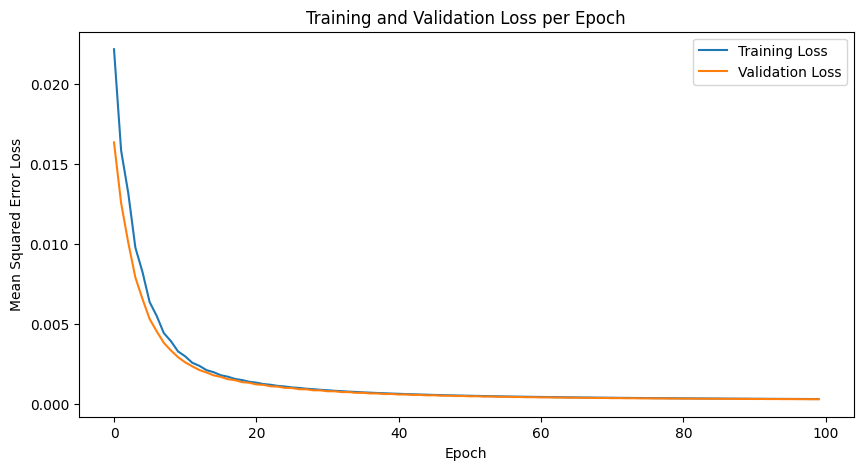

In [13]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Assuming 'meta' is pre-loaded and processed as described previously
X = meta.iloc[:, 1:5].values  # Assuming the first column is the target
y = meta.iloc[:, 0:1].values

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# Scaling data
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Converting to torch tensors
training = torch.tensor(X_train_scaled, dtype=torch.float32)
test = torch.tensor(X_test_scaled, dtype=torch.float32)
trainlabels = torch.tensor(y_train_scaled, dtype=torch.float32)
testlabels = torch.tensor(y_test_scaled, dtype=torch.float32)

class MLP(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(num_inputs, num_hiddens)  # Correct variable names here
        nn.init.kaiming_uniform_(self.hidden.weight, nonlinearity='relu')  # Initializing weights
        self.activation = nn.ReLU()
        self.out = nn.Linear(num_hiddens, num_outputs)  # Correct variable names here

    def forward(self, X):
        X = self.hidden(X)
        X = self.activation(X)
        X = self.out(X)
        return X

# Model specifics
num_input, num_output, num_hidden = 4, 1, 4
model_1 = MLP(num_input, num_output, num_hidden)
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.5)

# Storage for loss history
train_hist_mlp1 = np.zeros(100)
val_hist_mlp1 = np.zeros(100)

# Training the model with validation loss computation
for epoch in range(100):
    optimizer.zero_grad()
    
    # Training step
    y_pred_train = model_1(training)
    l_train = loss(y_pred_train, trainlabels)
    l_train.backward()
    optimizer.step()
    
    # Validation step
    with torch.no_grad():
        y_pred_val = model_1(test)
        l_val = loss(y_pred_val, testlabels)
    
    # Store losses
    train_hist_mlp1[epoch] = l_train.item()
    val_hist_mlp1[epoch] = l_val.item()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Training MSE: {l_train.item()}, Validation MSE: {l_val.item()}")

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_hist_mlp1, label='Training Loss')
plt.plot(val_hist_mlp1, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()


Epoch 0: Training MSE: 0.16864076256752014, Validation MSE: 0.21529196202754974
Epoch 10: Training MSE: 0.08630993217229843, Validation MSE: 0.08208295702934265
Epoch 20: Training MSE: 0.08573950827121735, Validation MSE: 0.08133482187986374
Epoch 30: Training MSE: 0.08522746711969376, Validation MSE: 0.08104199171066284
Epoch 40: Training MSE: 0.08554410934448242, Validation MSE: 0.0810253694653511
Epoch 50: Training MSE: 0.08538883179426193, Validation MSE: 0.08106733858585358
Epoch 60: Training MSE: 0.08556414395570755, Validation MSE: 0.0810759961605072
Epoch 70: Training MSE: 0.0853048637509346, Validation MSE: 0.08107118308544159
Epoch 80: Training MSE: 0.08513263612985611, Validation MSE: 0.0810762271285057
Epoch 90: Training MSE: 0.08537337929010391, Validation MSE: 0.08107786625623703


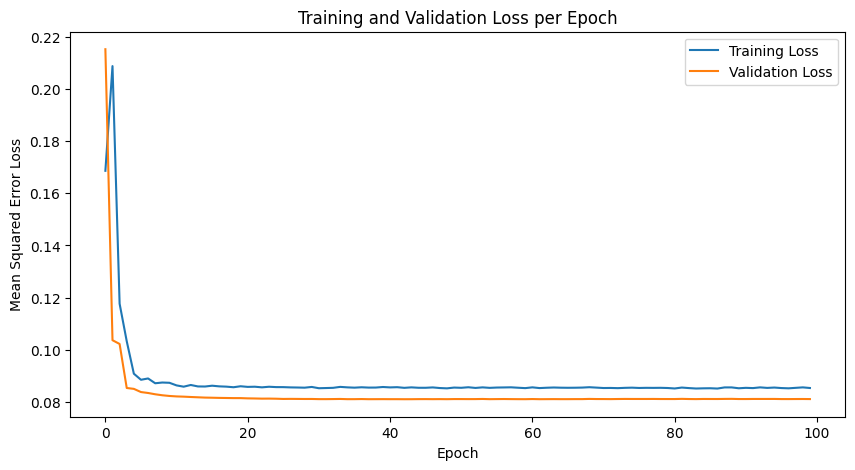

In [24]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Simulating the previous environment setup
# Assuming 'meta' has a 'Close' column with financial data
# Example data setup
np.random.seed(0)
meta = pd.DataFrame({
    'Close': np.random.random(1000) * 1000  # Random close prices
})

# Prepare closing prices for training
closing = meta[['Close']]
scaler = MinMaxScaler(feature_range=(0, 1))
closing['Close'] = scaler.fit_transform(closing['Close'].values.reshape(-1,1))

# Function to split data into sequences
def split_data(data, timeframe):
    numpydata = data.to_numpy()
    data = []
    for index in range(len(numpydata) - timeframe):
        data.append(numpydata[index: index + timeframe])
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - test_set_size
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    return [x_train, y_train, x_test, y_test]

# Split the data
timeframe = 31
x_train, y_train, x_test, y_test = split_data(closing, timeframe)
x_train = torch.from_numpy(x_train).type(torch.Tensor).view(-1, 30)
x_test = torch.from_numpy(x_test).type(torch.Tensor).view(-1, 30)
y_train= torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

# MLP model with dropout
class MLP(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(num_inputs, num_hiddens)
        nn.init.kaiming_uniform_(self.hidden.weight, nonlinearity='relu')
        self.dropout = nn.Dropout(0.2)
        self.activation = nn.ReLU()
        self.out = nn.Linear(num_hiddens, num_outputs)

    def forward(self, X):
        X = self.hidden(X)
        X = self.dropout(X)
        X = self.activation(X)
        X = self.out(X)
        return X

# Define the loss function and optimizer
loss = nn.MSELoss()
model_1 = MLP(30, 1, 4)  # Model initialization
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.5)

# Storage for training and validation history
train_hist_mlp2 = np.zeros(100)
val_hist_mlp2 = np.zeros(100)

# Training the model with validation loss computation
for epoch in range(100):
    model_1.train()  # Ensure model is in training mode
    optimizer.zero_grad()
    
    # Training step
    y_pred_train = model_1(x_train)
    l_train = loss(y_pred_train, y_train)
    l_train.backward()
    optimizer.step()
    
    # Validation step
    model_1.eval()  # Set model to evaluation mode
    with torch.no_grad():
        y_pred_val = model_1(x_test)
        l_val = loss(y_pred_val, y_test)
    
    # Store losses
    train_hist_mlp2[epoch] = l_train.item()
    val_hist_mlp2[epoch] = l_val.item()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Training MSE: {l_train.item()}, Validation MSE: {l_val.item()}")

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_hist_mlp2, label='Training Loss')
plt.plot(val_hist_mlp2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()


## CNN—MLP ##

C:\Users\23713\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([775, 1])) that is different to the input size (torch.Size([775])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\23713\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([194, 1])) that is different to the input size (torch.Size([194])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: Train Loss 0.35900238156318665, Val Loss 0.3548293113708496
Epoch 10: Train Loss 0.2161603569984436, Val Loss 0.21518735587596893
Epoch 20: Train Loss 0.14353293180465698, Val Loss 0.14264501631259918
Epoch 30: Train Loss 0.10848743468523026, Val Loss 0.10706506669521332
Epoch 40: Train Loss 0.09357790648937225, Val Loss 0.0913265198469162
Epoch 50: Train Loss 0.08808574080467224, Val Loss 0.08507268130779266
Epoch 60: Train Loss 0.08630243688821793, Val Loss 0.08273253589868546
Epoch 70: Train Loss 0.08577138930559158, Val Loss 0.08185149729251862
Epoch 80: Train Loss 0.08562128990888596, Val Loss 0.08150070905685425
Epoch 90: Train Loss 0.0855800062417984, Val Loss 0.08135002106428146


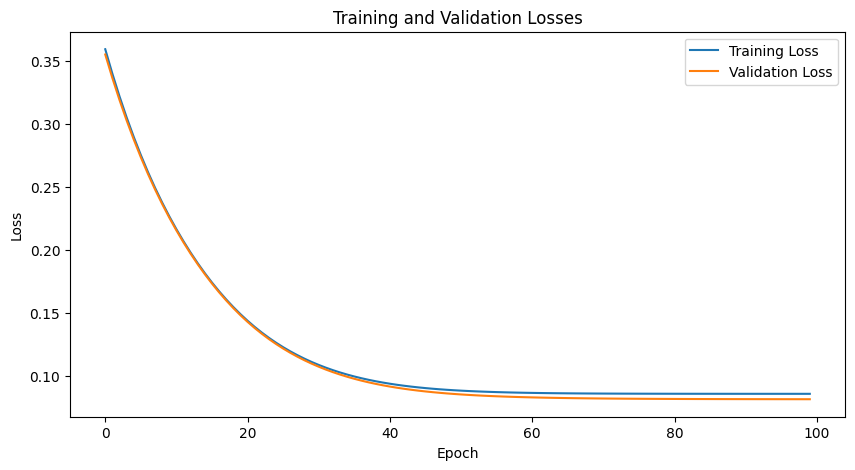

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 假设数据已经按照前面的方式处理好，包括x_train, y_train, x_test, y_test

# CNN-MLP模型定义
class CNN_MLP(nn.Module):
    def __init__(self):
        super(CNN_MLP, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 7, 50),  # Assuming input sequence length is 30, after two pooling it is 30/4=7.5 approx 7
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

# 初始化模型、损失函数和优化器
model = CNN_MLP()
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 训练模型
train_losses, val_losses = [], []
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    y_pred = model(x_train.unsqueeze(1))  # Add channel dimension
    loss = loss_fn(y_pred.squeeze(), y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        y_val_pred = model(x_test.unsqueeze(1))  # Add channel dimension
        val_loss = loss_fn(y_val_pred.squeeze(), y_test)
        val_losses.append(val_loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train Loss {loss.item()}, Val Loss {val_loss.item()}")

# 绘制训练和验证损失
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


C:\Users\23713\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([775, 1])) that is different to the input size (torch.Size([775])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\23713\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([194, 1])) that is different to the input size (torch.Size([194])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


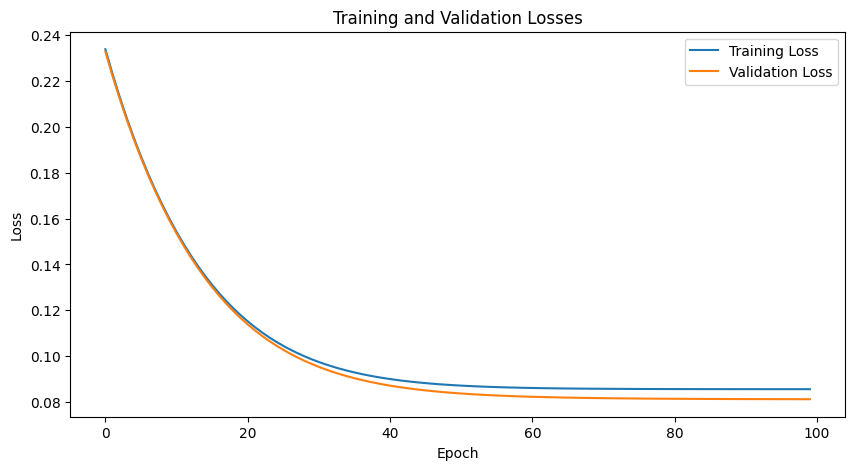

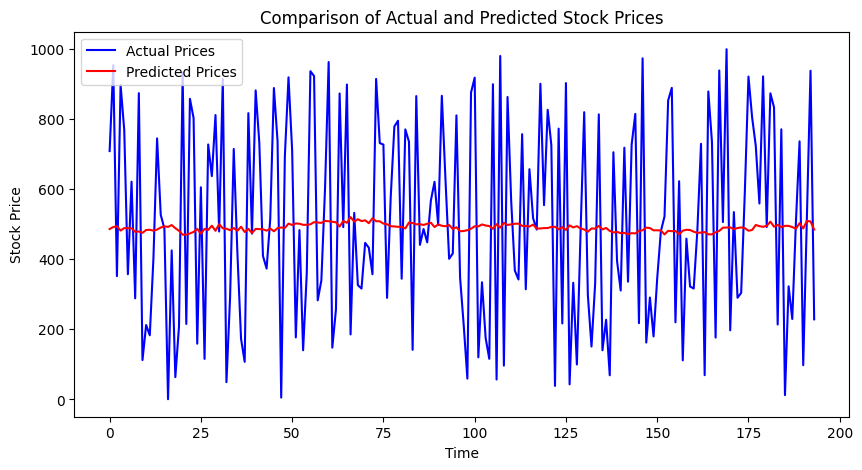

In [26]:
# 准备收盘价数据进行训练
closing = meta[['Close']]
scaler = MinMaxScaler(feature_range=(0, 1))
closing['Close'] = scaler.fit_transform(closing['Close'].values.reshape(-1,1))

# 分割数据函数
def split_data(data, timeframe):
    numpydata = data.to_numpy()
    data = []
    for index in range(len(numpydata) - timeframe):
        data.append(numpydata[index: index + timeframe])
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - test_set_size
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    return [x_train, y_train, x_test, y_test]

# 设置时间帧并分割数据
timeframe = 31
x_train, y_train, x_test, y_test = split_data(closing, timeframe)
x_train = torch.from_numpy(x_train).type(torch.Tensor).view(-1, 30)
x_test = torch.from_numpy(x_test).type(torch.Tensor).view(-1, 30)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

# CNN-MLP模型定义
class CNN_MLP(nn.Module):
    def __init__(self):
        super(CNN_MLP, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 7, 50),  # Assuming input sequence length is 30, after two pooling it is 30/4=7.5 approx 7
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        x = x.view(x.size(0), 1, -1)  # Add channel dimension
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

# 初始化模型、损失函数和优化器
model = CNN_MLP()
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 训练模型并计算验证损失
train_losses, val_losses = [], []
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    y_pred_train = model(x_train)
    loss_train = loss_fn(y_pred_train.squeeze(), y_train)
    loss_train.backward()
    optimizer.step()
    train_losses.append(loss_train.item())

    model.eval()
    with torch.no_grad():
        y_pred_val = model(x_test)
        loss_val = loss_fn(y_pred_val.squeeze(), y_test)
        val_losses.append(loss_val.item())

# 绘制训练和验证损失图
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# 预测结果与实际股价对比图
y_pred_test = model(x_test).detach().numpy()
y_test_actual = y_test.detach().numpy()

# 反归一化预测与实际股价
y_pred_test_actual = scaler.inverse_transform(y_pred_test)
y_test_actual = scaler.inverse_transform(y_test_actual.reshape(-1, 1))


# 绘制预测结果与实际股价对比图
plt.figure(figsize=(10, 5))
plt.plot(y_test_actual, label='Actual Prices', color='blue')
plt.plot(y_pred_test_actual, label='Predicted Prices', color='red')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Comparison of Actual and Predicted Stock Prices')
plt.legend()
plt.show()

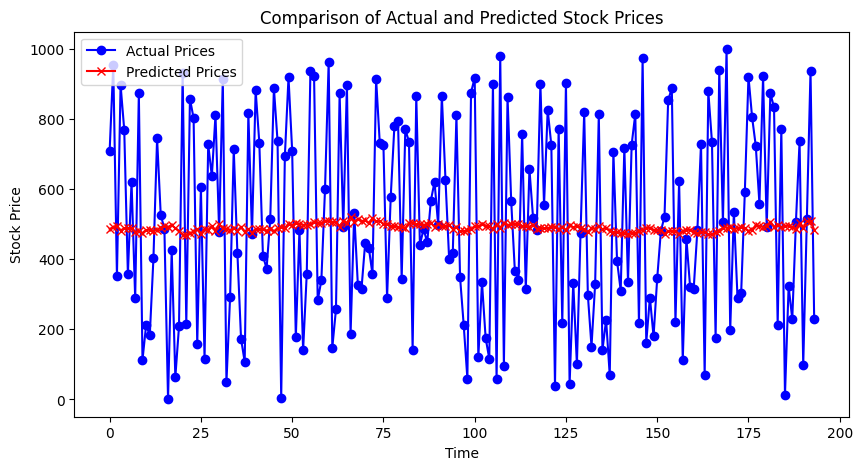

In [30]:
# 绘制预测结果与实际股价对比图
plt.figure(figsize=(10, 5))
plt.plot(y_test_actual, label='Actual Prices', color='blue', marker='o')
plt.plot(y_pred_test_actual, label='Predicted Prices', color='red', marker='x')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Comparison of Actual and Predicted Stock Prices')
plt.legend()
plt.show()